In [2]:
%load_ext autoreload
%autoreload 2

import argparse
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import yaml
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

import src.BertClassifier as BertClassifier
import src.utils as utils
import wandb
from src.datasets import create_loo_dataset, create_test_sst2, create_train_sst2

device = utils.get_device()

# config = utils.load_config(
#     "bert_classifier.yaml", epochs=10, num_training_examples=1000
# )

# # Create datasets
# train_dataset = create_train_sst2(
#     device,
#     num_samples=config["num_training_examples"],
#     tokenizer_name=config["bert_model_name"],
#     max_seq_len=config["max_sequence_length"],
# )

# test_dataset = create_test_sst2(
#     device,
#     tokenizer_name=config["bert_model_name"],
#     max_seq_len=config["max_sequence_length"],
# )
# test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
guids = [1, 3, 4, 11, 12, 13, 102, 435]

df = pd.read_csv('loo_pct_10k/1-sweep.csv')

In [5]:
df[df.test_guid == 1]

,test_guid,logits,pred,label,loss,type,remove_pct
1,1,[ 1.4445747 -1.3109552],0,0,0.061636,rand,0.05
873,1,[ 0.83265924 -0.6990555 ],0,0,0.195702,top,0.05
1745,1,[ 2.9275093 -2.7938893],0,0,0.003270,bot,0.05
2617,1,[ 1.4685506 -1.3349336],0,0,0.058833,zero,0.05
3489,1,[ 1.3481927 -1.2145786],0,0,0.074264,rand,0.10
4361,1,[ 0.5487053 -0.41509557],0,0,0.323127,top,0.10
5233,1,[ 3.6039524 -3.4703414],0,0,0.000846,bot,0.10
6105,1,[ 1.5535678 -1.4199393],0,0,0.049860,zero,0.10
6977,1,[ 1.2704108 -1.1367943],0,0,0.086239,rand,0.15
7849,1,[ 0.43950123 -0.30589908],0,0,0.388349,top,0.15


In [21]:
def train_model(
    train_dataset, test_dataset, config, wandb_project="LOO-test", wandb_tags=None
):
    train_dataloader = DataLoader(
        train_dataset, batch_size=config["batch_size"], shuffle=True
    )

    # Create classifcation model
    model = BertClassifier.create_bert_classifier(
        config["bert_model_name"],
        classifier_type=config["classifier_type"],
        classifier_hidden_size=config["classifier_hidden_size"],
        classifier_drop_out=config["classifier_drop_out"],
        freeze_bert=True,
        # random_state=42,
    )
    model.classifier.load_state_dict(
        torch.load("loo_10k/run_0/init_classifier_params.pt")
    )
    # torch.save(model.classifier.state_dict(), 'classifier_params.pt')

    optimizer = Adam(model.classifier.parameters(), lr=config["learning_rate"])
    loss_fn = torch.nn.CrossEntropyLoss()

    run = wandb.init(project=wandb_project, tags=wandb_tags, config=config)

    utils.train(
        config=config,
        model=model,
        optimizer=optimizer,
        train_dataloader=train_dataloader,
        val_dataloader=None,
    )

    fdf, test_loss, test_acc = utils.evaluate_loss_df(model, test_dataloader)
    wandb.summary["test/loss"] = test_loss
    wandb.summary["test/accuracy"] = test_acc
    wandb.finish()

    return model, fdf, test_loss, test_acc


full_model, fdf, full_test_loss, full_test_acc = train_model(
    train_dataset, test_dataset, config
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
wandb: Currently logged in as: patcao. Use `wandb login --relogin` to force relogin


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:20<00:00, 30.86batch/s]


epoch,▁▃▅▆█
train/accuracy,▁▇▇██
train/batch_loss,▇▆▅▅▅▄▃▆█▄▅▂▇▄▆▃▃▆▂▃▅▁▂▂▃▂▃▄▁▄▂▂▆█▂▃▅▅▂▃
train/loss,█▃▃▂▁
epoch,5
test/accuracy,83.83028
test/loss,0.38231
train/accuracy,84.2
train/batch_loss,0.08196
train/loss,0.35668


In [34]:
firstq_loss = fdf.loss.quantile(0.25)
median_loss = fdf.loss.quantile(0.5)
thirdq_loss = fdf.loss.quantile(0.75)

In [42]:
df = fdf.copy()

In [48]:
# df = df.sort_values('loss')
# df['rank'] = 1
# df['rank'] = df['rank'].cumsum()
# df.sort_index().iloc[:15]

In [49]:
fdf[(fdf.loss >= firstq_loss) & (fdf.loss < median_loss)].iloc[:2]

,test_guid,logits,pred,label,loss
1,1,"[1.5613662, -1.4277569]",0,0,0.049106
3,3,"[-1.7622392, 1.5963509]",1,1,0.034193


In [50]:
fdf[(fdf.loss >= median_loss) & (fdf.loss < thirdq_loss)].iloc[:2]

,test_guid,logits,pred,label,loss
4,4,"[0.900454, -1.1592299]",0,0,0.119998
12,12,"[0.6718131, -0.91679406]",0,0,0.185824


In [51]:
fdf[(fdf.loss >= thirdq_loss)].iloc[:2]

,test_guid,logits,pred,label,loss
11,11,"[-0.2477861, 0.17904276]",1,0,0.929164
13,13,"[0.2667944, -0.8268993]",0,1,1.382608


### Compare Loo Pct Results

In [57]:
test_guids = [1, 3, 4, 11, 12, 13]

fdf[fdf.test_guid.isin(test_guids)]

,test_guid,logits,pred,label,loss
1,1,"[1.5613662, -1.4277569]",0,0,0.049106
3,3,"[-1.7622392, 1.5963509]",1,1,0.034193
4,4,"[0.900454, -1.1592299]",0,0,0.119998
11,11,"[-0.2477861, 0.17904276]",1,0,0.929164
12,12,"[0.6718131, -0.91679406]",0,0,0.185824
13,13,"[0.2667944, -0.8268993]",0,1,1.382608


In [70]:
TEST_GUID = 13

df = pd.read_csv(f"loo_pct_10k/{TEST_GUID}-sweep.csv")
# base_line_loss = fdf[fdf.test_guid == TEST_GUID].loss.squeeze()

rand = df[(df.type == "rand") & (df.test_guid == TEST_GUID)]
rand = rand[["remove_pct", "loss"]]

zero = df[(df.type == "zero") & (df.test_guid == TEST_GUID)]
zero = zero[["remove_pct", "loss"]]

top = df[(df.type == "top") & (df.test_guid == TEST_GUID)]
top = top[["remove_pct", "loss"]]

bot = df[(df.type == "bot") & (df.test_guid == TEST_GUID)]
bot = bot[["remove_pct", "loss"]]

In [67]:
df[(df.type == "bot") & (df.test_guid == TEST_GUID)]

,test_guid,logits,pred,label,loss,type,remove_pct
1745,1,[ 2.9275093 -2.7938893],0,0,0.003270,bot,0.05
5233,1,[ 3.6039524 -3.4703414],0,0,0.000846,bot,0.10
8721,1,[ 3.8820407 -3.748429 ],0,0,0.000485,bot,0.15
12209,1,[ 4.3530107 -4.219398 ],0,0,0.000189,bot,0.20
15697,1,[ 4.8490567 -4.7154484],0,0,0.000070,bot,0.25
19185,1,[ 5.0338054 -4.9001975],0,0,0.000049,bot,0.30
22673,1,[ 5.7603045 -5.626695 ],0,0,0.000011,bot,0.40
26161,1,[ 6.2965884 -6.162979 ],0,0,0.000004,bot,0.50
29649,1,[ 9.374328 -9.240766],0,0,-0.000000,bot,0.60
33137,1,[ 8.934995 -8.801443],0,0,-0.000000,bot,0.70


In [68]:
df[(df.type == "zero") & (df.test_guid == TEST_GUID)]

,test_guid,logits,pred,label,loss,type,remove_pct
2617,1,[ 1.4685506 -1.3349336],0,0,0.058833,zero,0.05
6105,1,[ 1.5535678 -1.4199393],0,0,0.049860,zero,0.10
9593,1,[ 1.3734136 -1.239786 ],0,0,0.070738,zero,0.15
13081,1,[ 1.4255875 -1.2919562],0,0,0.063948,zero,0.20
16569,1,[ 1.2032921 -1.0696654],0,0,0.098040,zero,0.25
20057,1,[ 1.1711546 -1.037523 ],0,0,0.104221,zero,0.30
23545,1,[ 1.1718447 -1.0382004],0,0,0.104086,zero,0.40
27033,1,[ 0.9069178 -0.7732666],0,0,0.170873,zero,0.50
30521,1,[ 0.38372383 -0.25006297],0,0,0.425646,zero,0.60
34009,1,[ 0.1930658 -0.0593977],0,0,0.574862,zero,0.70


In [75]:
df[(df.type == "bot")].groupby('remove_pct').loss.mean()

remove_pct
0.05    0.460202
0.10    0.547598
0.15    0.666621
0.20    0.808063
0.25    1.032161
0.30    1.231065
0.40    1.794076
0.50    3.836545
0.60    3.977201
0.70    4.539891
Name: loss, dtype: float64

<Axes: xlabel='remove_pct'>

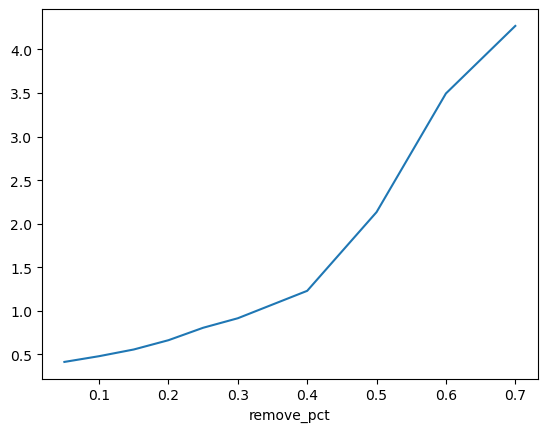

In [77]:
df[(df.type == "top")].groupby('remove_pct').loss.mean().plot()

<Axes: xlabel='remove_pct'>

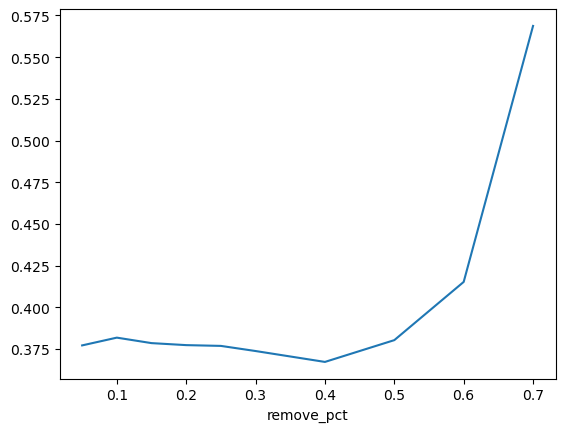

In [81]:
df[(df.type == "zero")].groupby('remove_pct').loss.mean().plot()

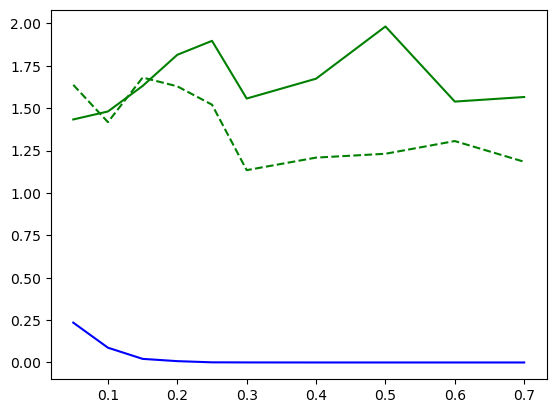

In [71]:
from matplotlib import pyplot as plt

plt.plot(rand.remove_pct, rand.loss, "g-")
plt.plot(zero.remove_pct, zero.loss, "g--")

# plt.plot(top.remove_pct, top.loss, 'r-')
plt.plot(bot.remove_pct, bot.loss, "b-")

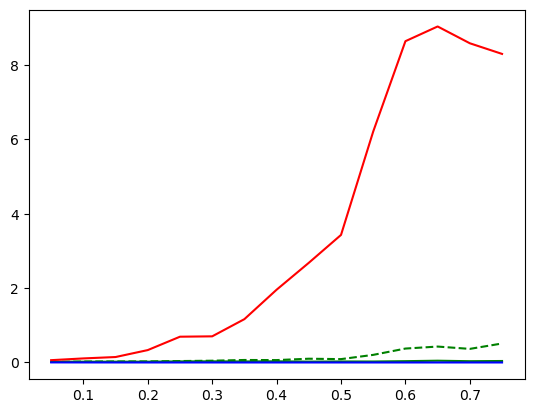

In [8]:
from matplotlib import pyplot as plt

plt.plot(rand.remove_pct, rand.loss, "g-")
plt.plot(zero.remove_pct, zero.loss, "g--")

plt.plot(top.remove_pct, top.loss, "r-")
plt.plot(bot.remove_pct, bot.loss, "b-")